### Course Project

In this project, you are asked to conduct a Monte Carlo study (i.e., a simulation analysis) on the performance of various MLE methods for a normal-truncated normal stochastic frontier model. 


Grading is based on:
- the log-likelihood functions and the DGP function: 65%
  - producing the correct answer is the basic requirement
- the simulation function and the result: 35%



#### What is the "normal-truncated normal stochastic frontier model"?

- Different from but similar to the normal-half normal stochastic frontier model in the previous homework.

- See Section 1.5.2 of the lecture note Lec14a.


#### What are the "various MLE methods"?

These are the methods introduced in Lec13 and Lec14b. They include:
- the standard MLE method,
- the conventional Monte Carlo simulation method,
- the numerical integration approach: the Gaussian quadrature method,
- the numerical integration approach: The Monte Carlo integration method.


#### What is a Monte Carlo study?

A Monte Carlo study is a computational approach that utilizes repeated random sampling to simulate and analyze complex models. It's used to test the efficacy of econometric methods, study the properties of estimators or testing procedures, and understand the behavior of complex systems when mathematical analysis is difficult. 


#### "_So, what exactly do I need to do in a simulation?_"

The process would look like the follows.

1. Generate data  for a normal-truncated normal stochastic frontier model.
  - You need to write a program similar to `DGP_nhn`.


2. Estimate the data using one of the estimation methods mentioned in Section 1.2 above.
  - You need to write programs similar to `NHN_mle`, `NHN_msle`, etc., in the previous homework.


3. Save the estimated parameters in a matrix.


4. Repeat Step 1 to 3 many times, so you get a big matrix.
  - The dimension of the big matrix is k-by-R (or R-by-k), where k is the number of parameters and R is the number of times the simulation is repeated.
  - You need to write a simulation program to automate the repetitive process.


5. Use the data in the big matrix to calculate the mean, the standard deviation, the minimum, and the maximum of the parameters for a given estimation method.
  - `describe()` from the `DataFrames` package would be helpful here.

**In the follows, we explain the major steps and specific requirements in detail.**


In [1]:
using DataFrames, Random, Distributions, HaltonSequences, FastGaussQuadrature, ForwardDiff, Optim, LinearAlgebra, LineSearches

### The Normal-Truncated Normal Model

Call this Model B. It is similar to the Model A (the Normal-Half Normal model) that you have done in the previous homework, though the estimation would be more challenging. The model is


\begin{align}
 y_i & = \alpha + x_i' \beta + v_i - u_i,\label{eq:front}\\
 v_i & \sim N(0, \sigma_v^2), \\
 u_i & \sim N^+(\mu, \sigma_u^2),\label{eq:ui}
\end{align}
 
\begin{aligned}
L_i =  -\frac{1}{2}\ln (\sigma_v^2 + \sigma_u^2) + \ln
\phi\left(\frac{\mu + \epsilon_i}{\sqrt{\sigma_v^2 + \sigma_u^2}} \right) +
\ln \Phi\left(\frac{\mu_{*i}}{\sigma_*} \right) -
\ln \Phi\left(\frac{\mu}{\sigma_u} \right),
\end{aligned}


where $\phi(z)$ and $\Phi(z)$ are the PDF and CDF of a standard normal distribution, and $N^+(\mu, \sigma_u^2)$ denotes a positive truncation of the normal distribution $N(\mu, \sigma_u^2)$. Also,

\begin{aligned}
 \mu_{*i}  = \frac{ \sigma_v^2 \mu-\sigma_u^2 \epsilon_i}{\sigma_v^2 + \sigma_u^2},\qquad
 \sigma_*^2  = \frac{\sigma_v^2  \sigma_u^2}{\sigma_v^2 + \sigma_u^2}. 
\end{aligned}

### Data Generating Program

The function should generate data of $y_i$ and $x_i$, $i=1,\ldots,N$ according to \eqref{eq:front} ~ \eqref{eq:ui}. It is similar to `DGP_nhn` that we used previously.

- Name the function `DGP_ntn`.
- Hint: To check whether `u` is correctly generated according to $N^+(\mu, \sigma_u^2)$: You may generate, say, 100,000 draws of $u$ and see if the mean and the variance of the data are close to the theoretical values.
  - In theory, the mean and the variance of $u\sim N^+(0.5,\ 2.0)$ are, respectively, $1.33052$ and $0.894977$.
  - In theory, the mean and the variance of $u\sim N^+(1.0,\ 3.0)$ are, respectively, $1.81447$ and $1.52217$.


In [2]:
# a suggested framework for DGP_ntn.
function DGP_ntn(; N::Int=10, nofx::Int=1, α=0.5, β::Vector=[0.5], μ=0.0, σᵤ²=1.0, σᵥ²=1.0) 
    # N: number of observations; 
    # nofx: number of x variables (excluding the constant α);
    # α: the intercept;
    # β: the coefficient vectors for $x$;
    
    length(β) == nofx || throw("The length of β should equal nofx.")
    
    x = rand(Normal(0,1), N, nofx)
    v = rand(Normal(0, sqrt(σᵥ²)), N)
    u = quantile(truncated(Normal(μ, sqrt(σᵤ²)); lower = 0), rand(N))
    
    y = α .+ x * β .+ v .- u
    
    return y, x   
end

DGP_ntn (generic function with 1 method)

### Write the Log-Likelihood Functions


#### Write the function for the MLE approach.
Write a Julia function for Model B's log-likelihood that is suitable for estimating using the plain old MLE approach (which is introduced in `Lec13 MLE.ipynb`). 

  - Name the function `NTN_mle`.
  - Hint: Very similar to that of your previous homework.
  

#### Write the function for the MSLE approach.

Write a Julia function for Model B's log-likelihood that is suitable for estimating using the Monte Carlo simulation approach (e.g., MCSA of Section 1.4 in the Lec14 lecture note). The function should have the following specifications.

  - Name the function `NTN_msle`.
  - Use **quasi** random numbers (instead of pseudo random numbers) for $u_i^s$, $s=1,\ldots,S$. 
  - You may use base-2 Halton draws and the suggested number of draws is $2^{10}-1$.
  - Hint: Very similar to that in the previous homework, with the exception that you used pseudo random numbers in the previous homework while you should use quasi random numbers here.



#### Write the function for the Gaussian quadrature integration approach.

Write a Julia function for Model B's log-likelihood that is suitable for estimating using the Guassian quadrature integration approach (e.g., NIA-GQ of Section 1.4.1.1 in the Lec14 lecture note). 

  - Name the function `NTN_gq`.
  - Suggested number of quadrature nodes is $180$.


#### Write the function for the quasi Monte Carlo integration approach.

Write a Julia function for Model B's log-likelihood that is suitable for estimating using the quasi Monte Carlo integration approach (e.g., NIA-MCI of Section 1.4.1.2 in the Lec14 lecture note). 

  - Name the function `NTN_qmc`.
  - Use the Quasi Monte Carlo method (not the pseudo Monte Carlo method) to do the integration. 
  - You may use base-2 Halton draws and the suggested number of draws is $2^{10}-1$.



In [3]:
function NTN_mle(y, x, α, β, μ, log_σ_u², log_σ_v²)
    σ_v² = exp(log_σ_v²)
    σ_v = exp(0.5 * log_σ_v²) 
    σ_u² = exp(log_σ_u²)
    σ_u = exp(0.5 * log_σ_u²) 
    σ_star² = (σ_v² * σ_u²) / (σ_v² + σ_u²)
    σ_star = sqrt(σ_star²)
    ϵ = y .- α .- x * β
    llike = 0.0       
    for i in eachindex(ϵ)
        μ_star_i = (σ_v² * μ - σ_u² * ϵ[i]) / (σ_v² + σ_u²) 
        term1 = -log(cdf(Normal(), μ / σ_u))
        term2 = -1/2 * log(σ_v² + σ_u²)
        term3 = log(pdf(Normal(), (μ + ϵ[i]) / sqrt(σ_v² + σ_u²)))
        term4 = log(cdf(Normal(), μ_star_i / σ_star))
        llike += term1 + term2 + term3 + term4
    end                                                      
    return llike = -llike
end


function NTN_msle(y, x, α, β, μ, log_σ_u², log_σ_v²)
    S = 2^10 - 1
    σ_v² = exp(log_σ_v²)
    σ_v = exp(0.5 * log_σ_v²)
    σ_u² = exp(log_σ_u²)
    σ_u = exp(0.5 * log_σ_u²)
    ϵ = y .- α .- x * β
    f(e, sigma_v) = pdf(Normal(0, sigma_v), e)
    u_tn = truncated(Normal(μ, σ_u); lower = 0)
    quasi = Halton(2, length = S)
    u_list = quantile(u_tn, quasi)
    logLike = Array{Real}(undef, size(y,1))
    for i in 1:size(y,1)
        logLike[i] = log(sum(f.(ϵ[i,1] .+ u_list, σ_v)/S))
    end
    return -sum(logLike)
end


function NTN_gq(y, x, α, β, μ, log_σ_u², log_σ_v²)
    nodes = 180
    σ_v² = exp(log_σ_v²)
    σ_v = exp(0.5 * log_σ_v²)
    σ_u² = exp(log_σ_u²)
    σ_u = exp(0.5 * log_σ_u²)
    ϵ = y .- α .- x * β
    fᵥ(e, sigma_v) = pdf(Normal(0, sigma_v), e)
    fᵤ(e, mu, sigma_u) = pdf(truncated(Normal(mu, sigma_u); lower = 0), e)
    f̃(p, q, sigmaᵥ, μμ, sigmaᵤ) = exp(q) * fᵥ(p + q, sigmaᵥ) * fᵤ(q, μμ, sigmaᵤ)
    logLike = Array{Real}(undef, size(y,1))
    xi, wi = gausslaguerre(nodes)
    for i in 1:size(y,1)
        logLike[i] = log(sum(wi .* f̃.(ϵ[i,1], xi, σ_v, μ, σ_u)))
    end
    return -sum(logLike)
end

function NTN_qmc(y, x, α, β, μ, log_σ_u², log_σ_v²)
    S = 2^16 - 1
    σ_v² = exp(log_σ_v²)
    σ_v = exp(0.5 * log_σ_v²)
    σ_u² = exp(log_σ_u²)
    σ_u = exp(0.5 * log_σ_u²)
    ϵ = y .- α .- x * β
    fᵥ(e, sigma_v) = pdf(Normal(0, sigma_v), e)
    fᵤ(e, mu, sigma_u) = pdf(truncated(Normal(mu, sigma_u); lower = 0), e)
    J(t) = 1 / (t - 1)^2
    h⁻¹(t) = t / (1 - t)
    g(p, q, sigmaᵥ, μμ, sigmaᵤ) = fᵥ(p + h⁻¹(q), sigmaᵥ) * fᵤ(h⁻¹(q), μμ, sigmaᵤ) * J(q)
    quasi = Halton(2, length = S)
    logLike = Array{Real}(undef, size(y,1))
    for i in 1:size(y,1)
        logLike[i] = log(sum(g.(ϵ[i,1], quasi, σ_v, μ, σ_u)/S))
    end
    return -sum(logLike)
end

NTN_qmc (generic function with 1 method)

### Show using the Indian data that all of the above methods produce similar results.
- Show me the coefficients; no need of standard errors and others.
- Hint: Strongly suggest using OLS results as the base to construct initial values.

In [4]:
using DataFrames, CSV
df = DataFrame(CSV.File("sampledata.csv"))
y = df[:, "yvar"]       # the dep var
x = Matrix(df[:, 2:7])  # the indep vars, not including a constant

x2=hcat(ones(size(y,1), 1), x); ols=inv(x2'x2)*(x2'y)

nofxvar = 6

func = TwiceDifferentiable(vars -> NTN_mle(y, x, vars[1], vars[2:nofxvar+1], vars[end - 2], vars[end - 1], vars[end]),
                           ones(nofxvar + 4); autodiff = :forward)

res = optimize(func, vcat(ols, 0.1126 * ones(3)), Newton(),
                Optim.Options(g_tol = 1e-9,
                              iterations = 1126) )
@show res

_coevec = Optim.minimizer(res)
res_coeff = deepcopy(_coevec)
res_coeff[end - 1] = exp(res_coeff[end - 1]) 
res_coeff[end] = exp(res_coeff[end])  

res_Hessian = Optim.hessian!(func, _coevec)  

var_cov_matrix = inv(res_Hessian)             
stderror = sqrt.(diag(var_cov_matrix))
stderror[end - 1] = res_coeff[end - 1] * stderror[end - 1]
stderror[end] = res_coeff[end] * stderror[end]  
t_stats = res_coeff ./ stderror
res_table = hcat(res_coeff, stderror, t_stats)

println("The estimation table is")
res_table |> display

func = TwiceDifferentiable(vars -> NTN_msle(y, x, vars[1], vars[2:nofxvar+1], vars[end - 2], vars[end - 1], vars[end]),
                           ones(nofxvar + 4); autodiff = :forward)

res = optimize(func, vcat(ols, 0.1126 * ones(3)), Newton(),
                Optim.Options(g_tol = 1e-9,
                              iterations = 1126) )
@show res

_coevec = Optim.minimizer(res)
res_coeff = deepcopy(_coevec)
res_coeff[end - 1] = exp(res_coeff[end - 1]) 
res_coeff[end] = exp(res_coeff[end])  

res_Hessian = Optim.hessian!(func, _coevec)

var_cov_matrix = inv(res_Hessian)         
stderror = sqrt.(diag(var_cov_matrix)) 
stderror[end - 1] = res_coeff[end - 1] * stderror[end - 1]
stderror[end] = res_coeff[end] * stderror[end]  
t_stats = res_coeff ./ stderror
res_table = hcat(res_coeff, stderror, t_stats)

println("The estimation table is")
res_table |> display

func = TwiceDifferentiable(vars -> NTN_gq(y, x, vars[1], vars[2:nofxvar+1], vars[end - 2], vars[end - 1], vars[end]),
                           ones(nofxvar + 4); autodiff = :forward)

res = optimize(func, vcat(ols, 0.1126 * ones(3)), Newton(),
                Optim.Options(g_tol = 1e-9,
                              iterations = 1126) )
@show res

_coevec = Optim.minimizer(res)
res_coeff = deepcopy(_coevec)
res_coeff[end - 1] = exp(res_coeff[end - 1]) 
res_coeff[end] = exp(res_coeff[end])  

res_Hessian = Optim.hessian!(func, _coevec)

var_cov_matrix = inv(res_Hessian)         
stderror = sqrt.(diag(var_cov_matrix)) 
stderror[end - 1] = res_coeff[end - 1] * stderror[end - 1]
stderror[end] = res_coeff[end] * stderror[end]  
t_stats = res_coeff ./ stderror
res_table = hcat(res_coeff, stderror, t_stats)

println("The estimation table is")
res_table |> display

func = TwiceDifferentiable(vars -> NTN_qmc(y, x, vars[1], vars[2:nofxvar+1], vars[end - 2], vars[end - 1], vars[end]),
                           ones(nofxvar + 4); autodiff = :forward)

res = optimize(func, vcat(ols, 0.1126 * ones(3)), Newton(),
                Optim.Options(g_tol = 1e-9,
                              iterations = 1126) )
@show res

_coevec = Optim.minimizer(res)
res_coeff = deepcopy(_coevec)
res_coeff[end - 1] = exp(res_coeff[end - 1]) 
res_coeff[end] = exp(res_coeff[end])  

res_Hessian = Optim.hessian!(func, _coevec)

var_cov_matrix = inv(res_Hessian)         
stderror = sqrt.(diag(var_cov_matrix)) 
stderror[end - 1] = res_coeff[end - 1] * stderror[end - 1]
stderror[end] = res_coeff[end] * stderror[end]  
t_stats = res_coeff ./ stderror
res_table = hcat(res_coeff, stderror, t_stats)

println("The estimation table is")
res_table |> display

res =  * Status: success

 * Candidate solution
    Final objective value:     9.160957e+01

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 3.25e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.01e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.01e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.10e-14 ≰ 0.0e+00
    |g(x)|                 = 5.65e-11 ≤ 1.0e-09

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    18
    f(x) calls:    50
    ∇f(x) calls:   50
    ∇²f(x) calls:  18

The estimation table is


10×3 Matrix{Float64}:
  1.53889     0.349306     4.40557
  0.293158    0.067602     4.33653
  0.239982    0.173592     1.38245
  1.14408     0.0824173   13.8815
 -0.41421     0.0584493   -7.08666
  0.00702936  0.0127031    0.553358
  0.0331732   0.00778711   4.26001
 -3.22249     7.49086     -0.43019
  1.20706     2.22921      0.541477
  0.0419195   0.011068     3.78746

res =  * Status: success

 * Candidate solution
    Final objective value:     9.147583e+01

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 4.76e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.48e-11 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.26e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.94e-14 ≰ 0.0e+00
    |g(x)|                 = 3.31e-10 ≤ 1.0e-09

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    29
    f(x) calls:    78
    ∇f(x) calls:   78
    ∇²f(x) calls:  29

The estimation table is


10×3 Matrix{Float64}:
  1.53904     0.349323     4.40579
  0.293156    0.0676028    4.33645
  0.239984    0.173599     1.38241
  1.1441      0.0824104   13.8829
 -0.414225    0.0584469   -7.0872
  0.00702902  0.0127031    0.553331
  0.033174    0.00778647   4.26047
 -3.20604     7.40091     -0.433195
  1.2019      2.20123      0.546015
  0.0419191   0.01107      3.78674

res =  * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     9.160966e+01

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 8.26e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.56e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.42e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.64e-15 ≰ 0.0e+00
    |g(x)|                 = 2.91e-11 ≤ 1.0e-09

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    19
    f(x) calls:    55
    ∇f(x) calls:   55
    ∇²f(x) calls:  19

The estimation table is


10×3 Matrix{Float64}:
  1.53893     0.349368     4.40489
  0.293162    0.0676053    4.33637
  0.240007    0.173617     1.38239
  1.14407     0.082437    13.8781
 -0.4142      0.0584619   -7.08496
  0.00702979  0.0127035    0.553374
  0.0331715   0.00778961   4.25843
 -3.22409     7.49532     -0.430147
  1.20759     2.23055      0.541386
  0.0419192   0.0110728    3.78578

res =  * Status: success

 * Candidate solution
    Final objective value:     9.161150e+01

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 4.67e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.46e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.71e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.86e-15 ≰ 0.0e+00
    |g(x)|                 = 4.72e-11 ≤ 1.0e-09

 * Work counters
    Seconds run:   1149  (vs limit Inf)
    Iterations:    19
    f(x) calls:    55
    ∇f(x) calls:   55
    ∇²f(x) calls:  19

The estimation table is


10×3 Matrix{Float64}:
  1.53903     0.349291     4.40614
  0.293158    0.0676023    4.33651
  0.240004    0.173592     1.38258
  1.14406     0.082415    13.8817
 -0.4142      0.058449    -7.08652
  0.00703039  0.0127031    0.553438
  0.0331716   0.00778704   4.25986
 -3.21054     7.44834     -0.431041
  1.20363     2.21683      0.54295
  0.0419065   0.0110648    3.78738

### Write the Simulation Function

#### What is a simulation function

A simulation function is essentially a computer program that allows us to create a virtual environment where we can model and replicate various scenarios, processes, or systems. This can help us predict outcomes, test theories, or understand the potential impact of different variables on a particular system. 

In the context of statistics and data science, a simulation function is often used to generate random data samples according to a certain distribution or model, perform some sort of analysis on that data (like estimate a statistical model), and then record the results. By repeating this process many times, we can understand the potential variability in our results or test the performance of our analysis method under different conditions. 

In this project, you are asked to write a simulation function that will:

1. Draw random samples of data for Model B.

2. Estimate Model B using one of the estimation methods.

3. Save the estimated parameters in a big matrix.

4. Repeat the entire process for $R$ times where $R$ is the number of simulation runs.

By doing this with a sufficiently large $R$ (such as 1,000), you essentially create a distribution of possible outcomes of the estimates, which they can then be analyzed to gain insights about the characteristics of the estimation method (e.g., its bias, variance, or robustness to certain conditions).


#### Required Specs:

- Need a random seed such that the results could be re-produced.
- You may use true values as the initial values.
- Check if the iteration limit is reached.
- Check the convergence criterion based on the norm of gradients.

In [5]:
###### suggested framework for the simulation function

function runSim(pgm::Function; R::Int=10,  N::Int=100, nofx::Int=1, α=0.5, 
                β::Vector=[0.5], μ=0.0, σᵤ²=2.0, σᵥ²=1.0, maxit=50, gtol=1e-7, seed::Int=33668324)
    # pgm: NTN_mle, NTN_msle, etc.
    # R: number of iteration times
    # N, nofx, α, β, μ, σᵤ², σᵥ²: parameters pertaining to DGP_ntn
    # maxit, gtol: parameters for optimization
    
    
    Random.seed!(seed)
    cnt = 0
    coeff_matrix = 0
    
    while cnt < R
        y, x = DGP_ntn(N = N, nofx = nofx, α = α, β = β, μ = μ, σᵤ² = σᵤ², σᵥ² = σᵥ²)
#         @show y
#         @show x
#         x2 = hcat(ones(size(y,1), 1), x); ols = inv(x2'x2)*(x2'y)
#         vcat(α * ones(1), β, μ * ones(1), σᵤ² * ones(1), σᵥ² * ones(1)), Newton(linesearch = LineSearches.BackTracking()
#         @show cnt
        
        func = TwiceDifferentiable(vars -> pgm(y, x, vars[1], vars[2:nofx+1], vars[end - 2], vars[end - 1], vars[end]),
                           ones(nofx + 4); autodiff = :forward)
        res = optimize(func, 0.1126 * ones(nofx + 4), Newton(),
                Optim.Options(g_tol = gtol,
                              iterations = maxit) )
#         @show res
        if (res.g_residual <= gtol) & (res.iterations < maxit)
            if cnt == 0
                _coevec = Optim.minimizer(res)
                res_coeff = deepcopy(_coevec)
                res_coeff[end - 1] = exp(res_coeff[end - 1]) 
                res_coeff[end] = exp(res_coeff[end])
                coeff_matrix = deepcopy(res_coeff)
            else
                _coevec = Optim.minimizer(res)
                res_coeff = deepcopy(_coevec)
                res_coeff[end - 1] = exp(res_coeff[end - 1]) 
                res_coeff[end] = exp(res_coeff[end])
                coeff_matrix = hcat(coeff_matrix, res_coeff)
            end
            cnt += 1
        end
    end
    
    return coeff_matrix
end

runSim (generic function with 1 method)

### Run Simulations

- You need to run four sets of simulations, with the parameters specified in the following code box. Note that only the first set, which uses `NTN_mle`, would require $R=1000$. The other three sets would run $R=10$.

- For each set, produce a DataFrame table with the summary statistics of the estimates, including the mean, the standard deviation, the minimum, and the maximum.
  - Hint: Use `describe()` (e.g., `describe(df, :mean, :std, :min, :max)`) and produce something like the follows (you may ignore the last two rows).
  
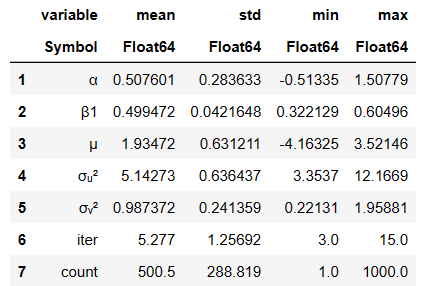

In [50]:
nofx = 1
variables = String[]
push!(variables,"α")
for i in 1:nofx
    push!(variables, "β$i")
end
push!(variables,"μ")
push!(variables, "σᵤ²")
push!(variables, "σᵥ²")

5-element Vector{String}:
 "α"
 "β1"
 "μ"
 "σᵤ²"
 "σᵥ²"

In [51]:
##### NTN_mle simulation
##### Use parameters specified in the example.
        
myres1 = runSim(NTN_mle, R=1000, N=500, nofx=1, α=0.5, β=[0.5], μ=2.0, 
               σᵤ²=5.0, σᵥ²=1.0, gtol=1e-7, maxit=30, seed=1126)

myres1 = transpose(myres1)

myres1 = DataFrame(myres1, :auto)
rename!(myres1, ["x$i" => vbs for (i, vbs) in enumerate(variables)])

describe(myres1, :mean, :std, :min, :max)
###### Produce a DataFrame table with the summary statistics.
                
        

Row,variable,mean,std,min,max
,Symbol,Float64,Float64,Float64,Float64
1,α,0.589707,0.61343,-0.84781,10.042
2,β1,0.503959,0.0822375,0.267263,0.835614
3,μ,1.76523,1.81405,-16.9361,12.4656
4,σᵤ²,5.57274,2.17495,0.25992,33.7703
5,σᵥ²,0.925106,0.460927,0.00636952,3.88694


In [52]:
##### NTN_msle simulation
##### Use parameters specified in the example.
        
myres2 = runSim(NTN_msle, R=10, N=500, nofx=1, α=0.5, β=[0.5], μ=2.0, 
               σᵤ²=5.0, σᵥ²=1.0, gtol=1e-7, maxit=30, seed=1126)

myres2 = transpose(myres2)

myres2 = DataFrame(myres2, :auto)
rename!(myres2, ["x$i" => vbs for (i, vbs) in enumerate(variables)])

describe(myres2, :mean, :std, :min, :max)
###### Produce a DataFrame table with the summary statistics.
                

Row,variable,mean,std,min,max
,Symbol,Float64,Float64,Float64,Float64
1,α,0.282399,0.663709,-0.793937,1.4359
2,β1,0.530296,0.0819015,0.342433,0.648941
3,μ,0.917961,1.89931,-3.3326,3.2546
4,σᵤ²,6.10205,1.63115,4.29022,8.70616
5,σᵥ²,1.13304,0.633113,0.335471,2.38472


In [53]:
##### NTN_gq simulation
##### Use parameters specified in the example.
        
myres3 = runSim(NTN_gq, R=10, N=500, nofx=1, α=0.5, β=[0.5], μ=2.0, 
               σᵤ²=5.0, σᵥ²=1.0, gtol=1e-7, maxit=30, seed=1126)

myres3 = transpose(myres3)

myres3 = DataFrame(myres3, :auto)
rename!(myres3, ["x$i" => vbs for (i, vbs) in enumerate(variables)])

describe(myres3, :mean, :std, :min, :max)
###### Produce a DataFrame table with the summary statistics.
                

Row,variable,mean,std,min,max
,Symbol,Float64,Float64,Float64,Float64
1,α,0.362604,0.70771,-0.719558,1.63763
2,β1,0.531329,0.0778774,0.362197,0.653364
3,μ,1.24961,1.60625,-1.85015,3.50642
4,σᵤ²,5.69718,1.4118,4.07732,8.35025
5,σᵥ²,1.07515,0.66089,0.182222,2.37578


In [54]:
##### NTN_qmc simulation
##### Use parameters specified in the example.
        
myres4 = runSim(NTN_qmc, R=10, N=500, nofx=1, α=0.5, β=[0.5], μ=2.0, 
               σᵤ²=5.0, σᵥ²=1.0, gtol=1e-7, maxit=30, seed=1126)

myres4 = transpose(myres4)

myres4 = DataFrame(myres4, :auto)
rename!(myres4, ["x$i" => vbs for (i, vbs) in enumerate(variables)])

describe(myres4, :mean, :std, :min, :max)
###### Produce a DataFrame table with the summary statistics.
                

Row,variable,mean,std,min,max
,Symbol,Float64,Float64,Float64,Float64
1,α,0.363313,0.70817,-0.718562,1.64158
2,β1,0.531393,0.0777246,0.362832,0.653364
3,μ,1.25221,1.6037,-1.83876,3.51112
4,σᵤ²,5.69518,1.41065,4.07724,8.34869
5,σᵥ²,1.07464,0.660993,0.179626,2.37495
